# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [30]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

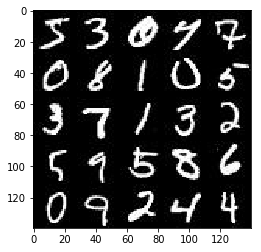

In [31]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

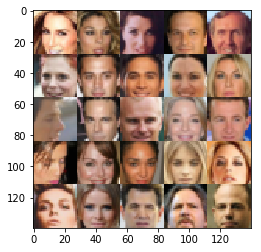

In [32]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [118]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [177]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [231]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
            return tf.maximum(x, alpha * x, name=name)
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3 
        x1 = tf.layers.conv2d(images, 16, 5, strides=2, padding='same')
        relu1 = leaky_relu(x1)
        # 14x14x16 now
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        # 7x7x64 now
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)
        # 4x4x256 now
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [252]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x16 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [253]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    label_smoothing = 0.9
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [254]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)   
        
    with tf.control_dependencies(update_ops):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [255]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [256]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_num in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # Generate noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})

                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_num+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3340... Generator Loss: 0.3207
Epoch 1/2... Discriminator Loss: 0.7830... Generator Loss: 1.2714
Epoch 1/2... Discriminator Loss: 0.6843... Generator Loss: 4.5969
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 2.1129
Epoch 1/2... Discriminator Loss: 0.4966... Generator Loss: 2.4910
Epoch 1/2... Discriminator Loss: 1.1030... Generator Loss: 1.3230
Epoch 1/2... Discriminator Loss: 0.5701... Generator Loss: 2.8855
Epoch 1/2... Discriminator Loss: 0.7743... Generator Loss: 1.6393
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 1.4424
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 1.2655


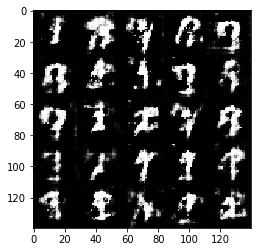

Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 2.6947
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 1.4824
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.5927
Epoch 1/2... Discriminator Loss: 1.0565... Generator Loss: 0.8787
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.7352
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 0.8953
Epoch 1/2... Discriminator Loss: 1.6700... Generator Loss: 0.4449
Epoch 1/2... Discriminator Loss: 1.3697... Generator Loss: 0.5777
Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 1.6760
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 1.3817


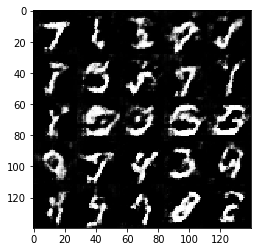

Epoch 1/2... Discriminator Loss: 1.1110... Generator Loss: 1.2782
Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.5252
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 1.1083
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 1.1929
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 0.6475
Epoch 1/2... Discriminator Loss: 1.4684... Generator Loss: 0.4663
Epoch 1/2... Discriminator Loss: 0.9791... Generator Loss: 1.0779
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.5794
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.5335


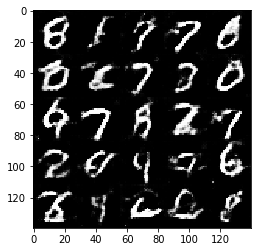

Epoch 1/2... Discriminator Loss: 1.7130... Generator Loss: 0.4027
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 0.5906
Epoch 1/2... Discriminator Loss: 1.0986... Generator Loss: 0.8109
Epoch 1/2... Discriminator Loss: 0.9130... Generator Loss: 1.0243
Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 1.1899
Epoch 1/2... Discriminator Loss: 0.9695... Generator Loss: 1.0765
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 0.6162
Epoch 1/2... Discriminator Loss: 1.8177... Generator Loss: 0.3448
Epoch 1/2... Discriminator Loss: 1.1704... Generator Loss: 0.7969


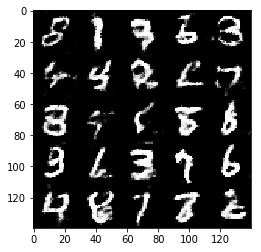

Epoch 1/2... Discriminator Loss: 2.4066... Generator Loss: 0.1966
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 0.8978
Epoch 1/2... Discriminator Loss: 0.7135... Generator Loss: 1.5172
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 1.3145
Epoch 1/2... Discriminator Loss: 0.8373... Generator Loss: 2.0580
Epoch 1/2... Discriminator Loss: 1.7249... Generator Loss: 0.3807
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.1450
Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 1.6925
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.6784
Epoch 1/2... Discriminator Loss: 0.8715... Generator Loss: 1.1381


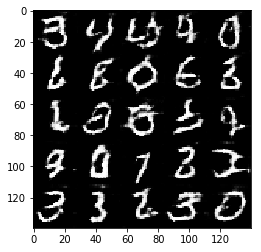

Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 2.9846
Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 1.7812
Epoch 1/2... Discriminator Loss: 1.0333... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 1.1517
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 1.2378
Epoch 1/2... Discriminator Loss: 1.0373... Generator Loss: 0.9305
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 0.9227
Epoch 1/2... Discriminator Loss: 0.9071... Generator Loss: 1.1036
Epoch 1/2... Discriminator Loss: 2.0005... Generator Loss: 0.3741
Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 1.1165


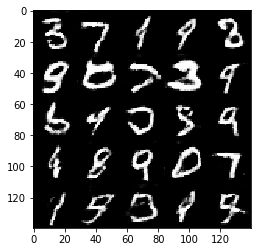

Epoch 1/2... Discriminator Loss: 2.2364... Generator Loss: 0.2447
Epoch 1/2... Discriminator Loss: 1.8425... Generator Loss: 0.3387
Epoch 1/2... Discriminator Loss: 1.0980... Generator Loss: 0.9049
Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 0.9260
Epoch 1/2... Discriminator Loss: 1.0424... Generator Loss: 1.3088
Epoch 1/2... Discriminator Loss: 0.4969... Generator Loss: 2.7829
Epoch 1/2... Discriminator Loss: 0.6494... Generator Loss: 1.6500
Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 1.3473
Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 0.8785
Epoch 1/2... Discriminator Loss: 0.8049... Generator Loss: 1.3579


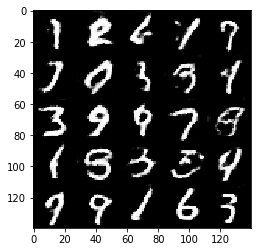

Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.5620
Epoch 1/2... Discriminator Loss: 0.6662... Generator Loss: 1.7651
Epoch 1/2... Discriminator Loss: 1.4768... Generator Loss: 0.6012
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 1.2135
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 1.0627
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 2.3131
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 0.7329
Epoch 2/2... Discriminator Loss: 0.8069... Generator Loss: 1.4739
Epoch 2/2... Discriminator Loss: 0.9471... Generator Loss: 0.8862
Epoch 2/2... Discriminator Loss: 0.6613... Generator Loss: 1.7337
Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 0.6402
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 2.3565
Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 0.7281


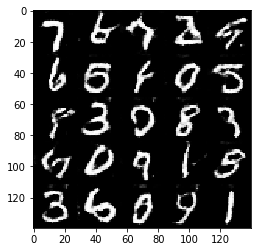

Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 0.7555
Epoch 2/2... Discriminator Loss: 1.0803... Generator Loss: 1.0732
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 0.6491
Epoch 2/2... Discriminator Loss: 0.8257... Generator Loss: 1.1564
Epoch 2/2... Discriminator Loss: 0.9924... Generator Loss: 0.9318
Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 2.2600
Epoch 2/2... Discriminator Loss: 1.1514... Generator Loss: 0.8849
Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.9575
Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.7102
Epoch 2/2... Discriminator Loss: 0.8448... Generator Loss: 1.0142


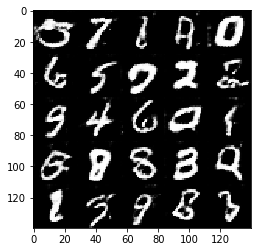

Epoch 2/2... Discriminator Loss: 0.7497... Generator Loss: 1.4119
Epoch 2/2... Discriminator Loss: 0.5987... Generator Loss: 1.7796
Epoch 2/2... Discriminator Loss: 1.8389... Generator Loss: 0.4124
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 1.2597
Epoch 2/2... Discriminator Loss: 1.0274... Generator Loss: 1.1120
Epoch 2/2... Discriminator Loss: 1.6954... Generator Loss: 0.4330
Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 0.9768
Epoch 2/2... Discriminator Loss: 0.5217... Generator Loss: 2.2120
Epoch 2/2... Discriminator Loss: 0.6135... Generator Loss: 1.7828
Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 1.8812


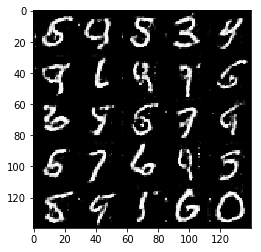

Epoch 2/2... Discriminator Loss: 1.5064... Generator Loss: 0.4672
Epoch 2/2... Discriminator Loss: 0.8048... Generator Loss: 1.2521
Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.5733
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.0425
Epoch 2/2... Discriminator Loss: 1.6495... Generator Loss: 0.4515
Epoch 2/2... Discriminator Loss: 0.7046... Generator Loss: 1.6742
Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 0.9240
Epoch 2/2... Discriminator Loss: 0.5510... Generator Loss: 2.2645
Epoch 2/2... Discriminator Loss: 1.2341... Generator Loss: 0.7311
Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 1.2799


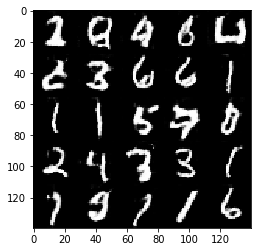

Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.7279
Epoch 2/2... Discriminator Loss: 1.1381... Generator Loss: 0.9485
Epoch 2/2... Discriminator Loss: 0.7969... Generator Loss: 1.3770
Epoch 2/2... Discriminator Loss: 1.4717... Generator Loss: 0.5312
Epoch 2/2... Discriminator Loss: 0.9031... Generator Loss: 1.0678
Epoch 2/2... Discriminator Loss: 1.2775... Generator Loss: 0.6244
Epoch 2/2... Discriminator Loss: 1.1479... Generator Loss: 0.8073
Epoch 2/2... Discriminator Loss: 0.9252... Generator Loss: 1.0448
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 1.5547


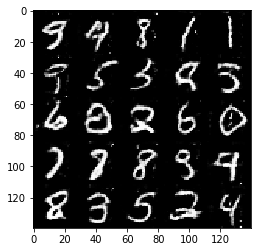

Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 0.8776
Epoch 2/2... Discriminator Loss: 3.1956... Generator Loss: 0.1361
Epoch 2/2... Discriminator Loss: 1.4418... Generator Loss: 0.9261
Epoch 2/2... Discriminator Loss: 0.8072... Generator Loss: 2.0941
Epoch 2/2... Discriminator Loss: 0.7832... Generator Loss: 1.3386
Epoch 2/2... Discriminator Loss: 1.0905... Generator Loss: 0.9158
Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.5144
Epoch 2/2... Discriminator Loss: 0.6631... Generator Loss: 1.5728
Epoch 2/2... Discriminator Loss: 1.0325... Generator Loss: 1.8162
Epoch 2/2... Discriminator Loss: 0.4226... Generator Loss: 3.3676


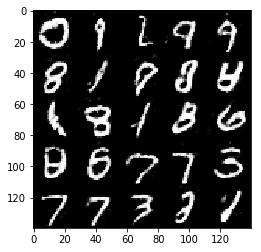

Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 0.9417
Epoch 2/2... Discriminator Loss: 1.0360... Generator Loss: 1.0999
Epoch 2/2... Discriminator Loss: 1.0554... Generator Loss: 0.8074
Epoch 2/2... Discriminator Loss: 0.5914... Generator Loss: 2.1945
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.6245
Epoch 2/2... Discriminator Loss: 0.5077... Generator Loss: 2.7168
Epoch 2/2... Discriminator Loss: 2.2065... Generator Loss: 0.4268
Epoch 2/2... Discriminator Loss: 0.5877... Generator Loss: 1.8578
Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.1460
Epoch 2/2... Discriminator Loss: 0.6181... Generator Loss: 1.7013


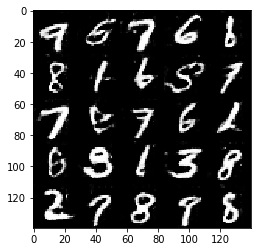

Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 1.4131
Epoch 2/2... Discriminator Loss: 0.5246... Generator Loss: 2.0344
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 1.7128
Epoch 2/2... Discriminator Loss: 0.7852... Generator Loss: 1.3803
Epoch 2/2... Discriminator Loss: 0.7230... Generator Loss: 1.8188


In [258]:
batch_size = 16
z_dim = 128
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 3.5969
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 1.3268
Epoch 1/1... Discriminator Loss: 1.8670... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 1.5434... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 1.0167


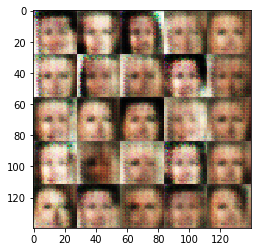

Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 1.3842
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7572


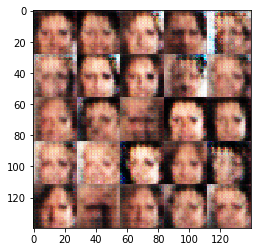

Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 1.6313
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.8915


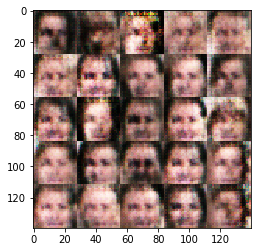

Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 1.3181
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 1.4566
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 1.0047


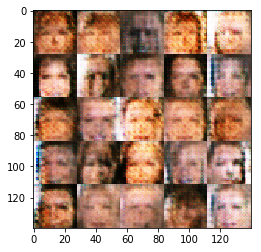

Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.8053


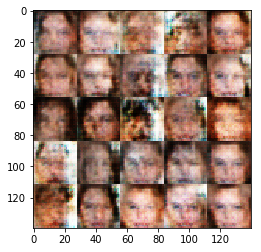

Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.1896
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.9508


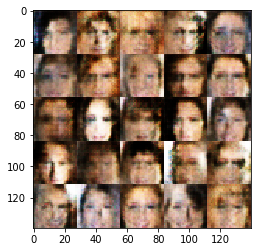

Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.2812
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 1.4930
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.6857


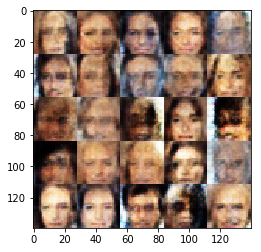

Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 1.1186
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.9271


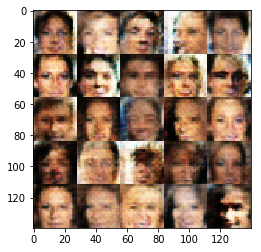

Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.5419


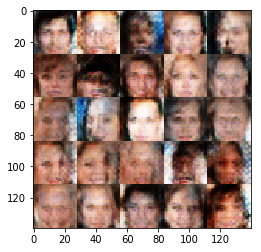

Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.2940
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.9308


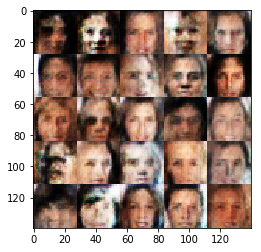

Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.9549


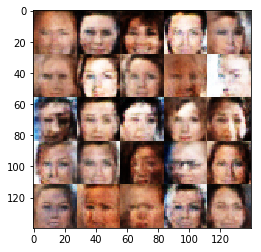

Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.4626
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7833


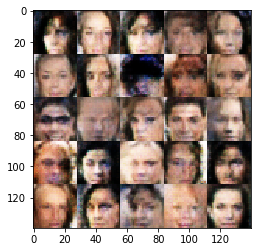

Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.8768


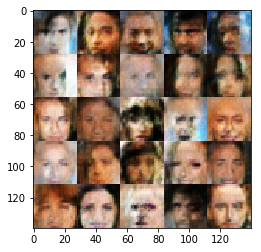

Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.7427


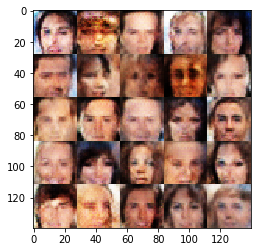

Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.6170


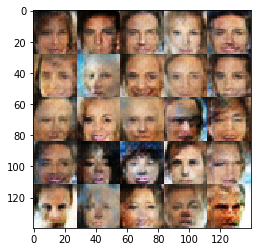

Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.7792


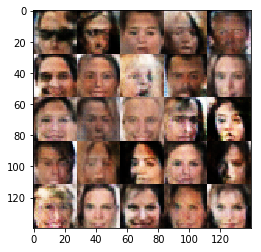

Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.8041


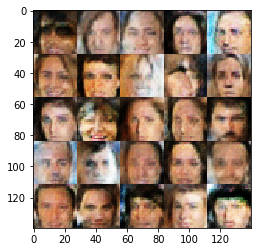

Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.8667


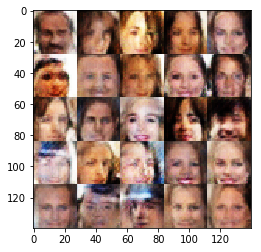

Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.0624


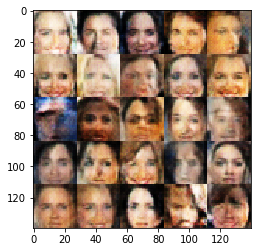

Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.1203
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 1.2146
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.8340


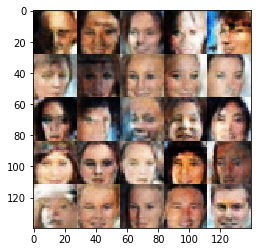

Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.9651


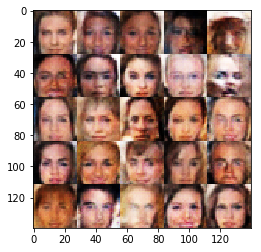

Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.7470


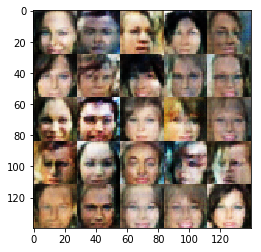

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.7853


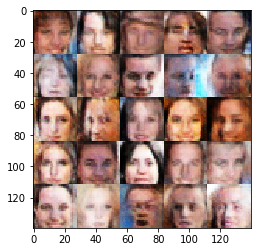

Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.6176... Generator Loss: 0.6070


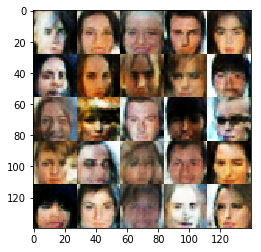

Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.6863


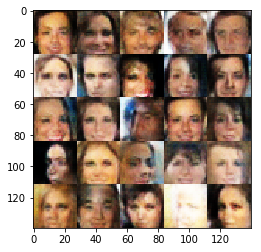

Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.8493


In [259]:
batch_size = 16
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.